In [1]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [2]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)

In [3]:
arxiv.invoke("attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [4]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)

In [5]:
wiki.invoke("What is machine learning?")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [6]:
from dotenv import load_dotenv
load_dotenv()  # take environment variables from .env.

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["Groq_API_KEY"]=os.getenv("Groq_API_Key")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("Langchain_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="ReAct-Agent"

In [7]:
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

def add(a: int, b: int) -> int:
    """Add two numbers."""
    return a + b

def divide(a: int, b: int) -> float:
    """Divide two numbers."""
    if b == 0:
        raise ValueError("Cannot divide by zero.")
    return a / b

In [ ]:
tools=[arxiv,wiki,multiply,add,divide,tavily]

In [9]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily= TavilySearchResults()


C:\Users\gakum\AppData\Local\Temp\ipykernel_2524\808923814.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily= TavilySearchResults()


In [10]:
tavily.invoke("Tell me about machine learning")

[{'title': 'DOE Explains...Machine Learning',
  'url': 'https://www.energy.gov/science/doe-explainsmachine-learning',
  'content': 'Image courtesy of Argonne National Laboratory \n\nMachine learning is the process of using computers to detect patterns in massive datasets and then make predictions based on what the computer learns from those patterns. This makes machine learning a specific and narrow type of artificial intelligence. Full artificial intelligence involves machines that can perform abilities we associate with the minds of human beings and intelligent animals, such as perceiving, learning, and problem solving. [...] All machine learning is based on algorithms. In general, algorithms are sets of specific instructions that a computer uses to solve problems. In machine learning, algorithms are rules for how to analyze data using statistics. Machine learning systems use these rules to identify relationships between data inputs and desired outputs–usually predictions. To get sta

In [11]:
tools=[arxiv,wiki,multiply,add,divide,tavily]

In [12]:
from langchain_groq import ChatGroq

groq_llm=ChatGroq(model="qwen/qwen3-32b")

llm_with_tools=groq_llm.bind_tools(tools)

In [13]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content="tell me about attentions is all you need reasearch paper")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking about the "Attention is All You Need" research paper. Let me recall what that paper is about. I think it introduced the Transformer model, which is a big deal in machine learning, especially for natural language processing. The key innovation was the self-attention mechanism, right? So first, I should confirm the details of the paper.\n\nWait, the user might want information on what the paper proposed, why it\'s important, and its impact. Since the paper is on arXiv, maybe I should use the arXiv tool to get the details. The title is "Attention Is All You Need" by Vaswani et al., published in 2017. But to be thorough, I should look it up to make sure I get the correct information.\n\nLet me use the arXiv function to search for the paper. The query should be the exact title or the authors\' names. Let me input "Attention Is All You Need" into the arXiv tool. Once I get the results, I can extract the r

In [14]:
llm_with_tools.invoke([HumanMessage(content="addd 5 and 6 then multiply with 10 and divide the value by 4 ")])

AIMessage(content='', additional_kwargs={'reasoning_content': "Okay, let's see. The user wants me to add 5 and 6 first. That's straightforward. 5 plus 6 is 11. Then they want me to multiply that result by 10. So 11 times 10 is 110. Next step is to divide that by 4. Hmm, 110 divided by 4. Let me check if I have a function for division. Yes, there's a divide function. So I need to call each operation step by step.\n\nWait, the tools provided include add, multiply, divide. So first, use add with 5 and 6. Then take the result and multiply by 10. Then take that result and divide by 4. Each step needs a separate function call. Let me make sure the parameters are integers. All numbers here are integers, so that's fine. Let's start with the add function.\n", 'tool_calls': [{'id': 'kag5qwhbs', 'function': {'arguments': '{"a":5,"b":6}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 221, 'prompt_tokens': 607, 'total_tokens': 828, 'completion_time':

In [15]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

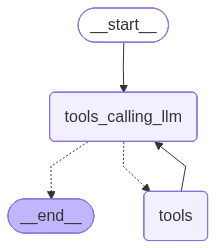

In [16]:
### Entire chatbot with LangGraph
from IPython.display import Image,display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition


## Node Defintion
def tool_calling_llm(state:State):
    return {"messages":llm_with_tools.invoke(state["messages"])}

##Build Graph
graph=StateGraph(State)
graph.add_node("tools_calling_llm",tool_calling_llm)
graph.add_node("tools",ToolNode(tools))

graph.add_edge(START,"tools_calling_llm")
graph.add_conditional_edges("tools_calling_llm",tools_condition)
graph.add_edge("tools", "tools_calling_llm")

builder=graph.compile()

display(Image(builder.get_graph().draw_mermaid_png()))






In [18]:
messages=builder.invoke({"messages":HumanMessage(content="addd 5 and 6 then multiply with 10 and divide the value by 4 and tell me significance of that number")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

addd 5 and 6 then multiply with 10 and divide the value by 4 and tell me significance of that number
================================== Ai Message ==================================
Tool Calls:
  add (e5sr0m01z)
 Call ID: e5sr0m01z
  Args:
    a: 5
    b: 6
================================= Tool Message =================================
Name: add

11
================================== Ai Message ==================================
Tool Calls:
  multiply (za1h3nven)
 Call ID: za1h3nven
  Args:
    a: 11
    b: 10
================================= Tool Message =================================
Name: multiply

110
================================== Ai Message ==================================
Tool Calls:
  divide (zwn77jkfg)
 Call ID: zwn77jkfg
  Args:
    a: 110
    b: 4
================================= Tool Message =================================
Name: divide

27.5
================================== Ai 

In [19]:
## Memory Integration

### Entire chatbot with LangGraph
from IPython.display import Image,display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition


## Node Defintion
def tool_calling_llm(state:State):
    return {"messages":llm_with_tools.invoke(state["messages"])}

##Build Graph
graph=StateGraph(State)
graph.add_node("tools_calling_llm",tool_calling_llm)
graph.add_node("tools",ToolNode(tools))

graph.add_edge(START,"tools_calling_llm")
graph.add_conditional_edges("tools_calling_llm",tools_condition)
graph.add_edge("tools", "tools_calling_llm")








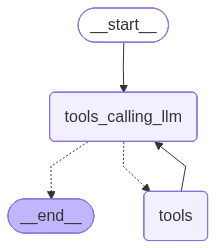

In [24]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

graph_memory=graph.compile(checkpointer=memory)

display(Image(graph_memory.get_graph().draw_mermaid_png()))

In [25]:
## Specify the Thread

config ={"configurable":{"thread_id":"22"}}

messages=[HumanMessage(content="addd 12 and 13 ")]
messages=graph_memory.invoke({"messages":messages},config=config)
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

addd 12 and 13 
================================== Ai Message ==================================
Tool Calls:
  add (9f39m3ff1)
 Call ID: 9f39m3ff1
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is **25**.


In [26]:
messages=[HumanMessage(content=" divide with 5 ")]
messages=graph_memory.invoke({"messages":messages},config=config)
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

addd 12 and 13 
================================== Ai Message ==================================
Tool Calls:
  add (9f39m3ff1)
 Call ID: 9f39m3ff1
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is **25**.
================================ Human Message =================================

 divide with 5 
================================== Ai Message ==================================
Tool Calls:
  divide (06000vexk)
 Call ID: 06000vexk
  Args:
    a: 25
    b: 5
================================= Tool Message =================================
Name: divide

5.0
================================== Ai Message ==================================

The result of dividing 25 by 5 is **5.0**.
